# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
import lightgbm as lgb

warnings.filterwarnings('ignore')
%matplotlib inline

pd.options.display.float_format = '{:,.3f}'.format
sns.set()

<h1><b> TRAIN DATA</b></h1>

# Load Dataset

In [2]:
pubg_data = pd.read_csv("/kaggle/input/pubg-finish-placement-prediction/train_V2.csv")
train = pubg_data

In [3]:
%%time
train.info()

# Memory usages in Bytes
print("Reduced Memory size: ",train.memory_usage(index=True).sum()/(1024*1024), "MB")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [4]:
# Memory usages in Bytes
print(train.memory_usage(index=True).sum()/(1024*1024), "MB")

983.9022064208984 MB


# Reducing Dataset Memory

### Here we are reducing the memory of the dataset by downcasting the datatypes of the column as small as possible so that there will be less time consumption for applying computational operations on it

In [5]:
for column_name in train:
    if train[column_name].dtype=='float64':
        train[column_name] = pd.to_numeric(train[column_name], downcast= 'float')
    if train[column_name].dtype=='int64':
        train[column_name] = pd.to_numeric(train[column_name],downcast='integer')

In [6]:
%%time
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float32
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float32
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float32
 21  roadKills        int8   
 22  swimDistance     float32
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float32
 26  weaponsAcquired  int16  
 27  winPoints   

### Here we can see memory is reduced by significant amount

In [7]:
# Memory usages in Bytes
print("Reduced Memory size: ",train.memory_usage(index=True).sum()/(1024*1024), "MB")

print("Data Description:")
train.describe().drop('count').T

Reduced Memory size:  339.2767028808594 MB
Data Description:


,mean,std,min,25%,50%,75%,max
assists,0.234,0.589,0.000,0.000,0.000,0.000,22.000
boosts,1.107,1.716,0.000,0.000,0.000,2.000,33.000
damageDealt,130.717,170.781,0.000,0.000,84.240,186.000,"6,616.000"
DBNOs,0.658,1.146,0.000,0.000,0.000,1.000,53.000
headshotKills,0.227,0.602,0.000,0.000,0.000,0.000,64.000
heals,1.370,2.680,0.000,0.000,0.000,2.000,80.000
killPlace,47.599,27.463,1.000,24.000,47.000,71.000,101.000
killPoints,505.006,627.505,0.000,0.000,0.000,"1,172.000","2,170.000"
kills,0.925,1.558,0.000,0.000,0.000,1.000,72.000
killStreaks,0.544,0.711,0.000,0.000,0.000,1.000,20.000


### Number of NULL value in Data

In [8]:
train.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

#### Here we can see there is only one null value for winPlacePerc feature, means it is an illegal match, hence we can drop that row as 1 row in compare to the size of the dataset won't affect the output!!

In [9]:
train.dropna(inplace=True)

#### Dropping the Id column as it will be of no use

In [10]:
train.drop(['Id'], axis=1, inplace=True)

In [11]:
labelencoder = LabelEncoder()

In [12]:
train['matchType'].value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536761
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

In [13]:
## So from the above there are many matchtypes with combination of fpp, tpp , solo, duo ,squad,etc.
## So we are generalizing them into only solo, duo and squad.
## After that applying LabelEncoding to matchType column

train['matchType'] = train['matchType'].apply(lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad')

train['matchType'] = labelencoder.fit_transform(train['matchType'])
train['matchType'].value_counts()

2    2403625
0    1322628
1     720712
Name: matchType, dtype: int64

In [14]:
train1 = train.copy()
# train2 = train.copy()

## EDA

In [15]:
train1.columns

Index(['groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

### Univariate Analysis

### Plotting graph for some of the discrete columns

In [16]:
# Discrete Columns
dis_cols_1 = ['assists', 'boosts', 'heals', 'DBNOs', 'headshotKills', 'kills']
dis_cols_2 = ['killStreaks', 'revives', 'roadKills', 'teamKills', 'weaponsAcquired','vehicleDestroys']

def discreteGraph(dis_cols):
    fig = plt.figure(figsize = (20, 15))

    index = 1
    for col in dis_cols:
        plt.subplot(3, 2, index)
        sns.countplot(x=col, data=train1)
        index += 1
    plt.tight_layout()
    plt.show()

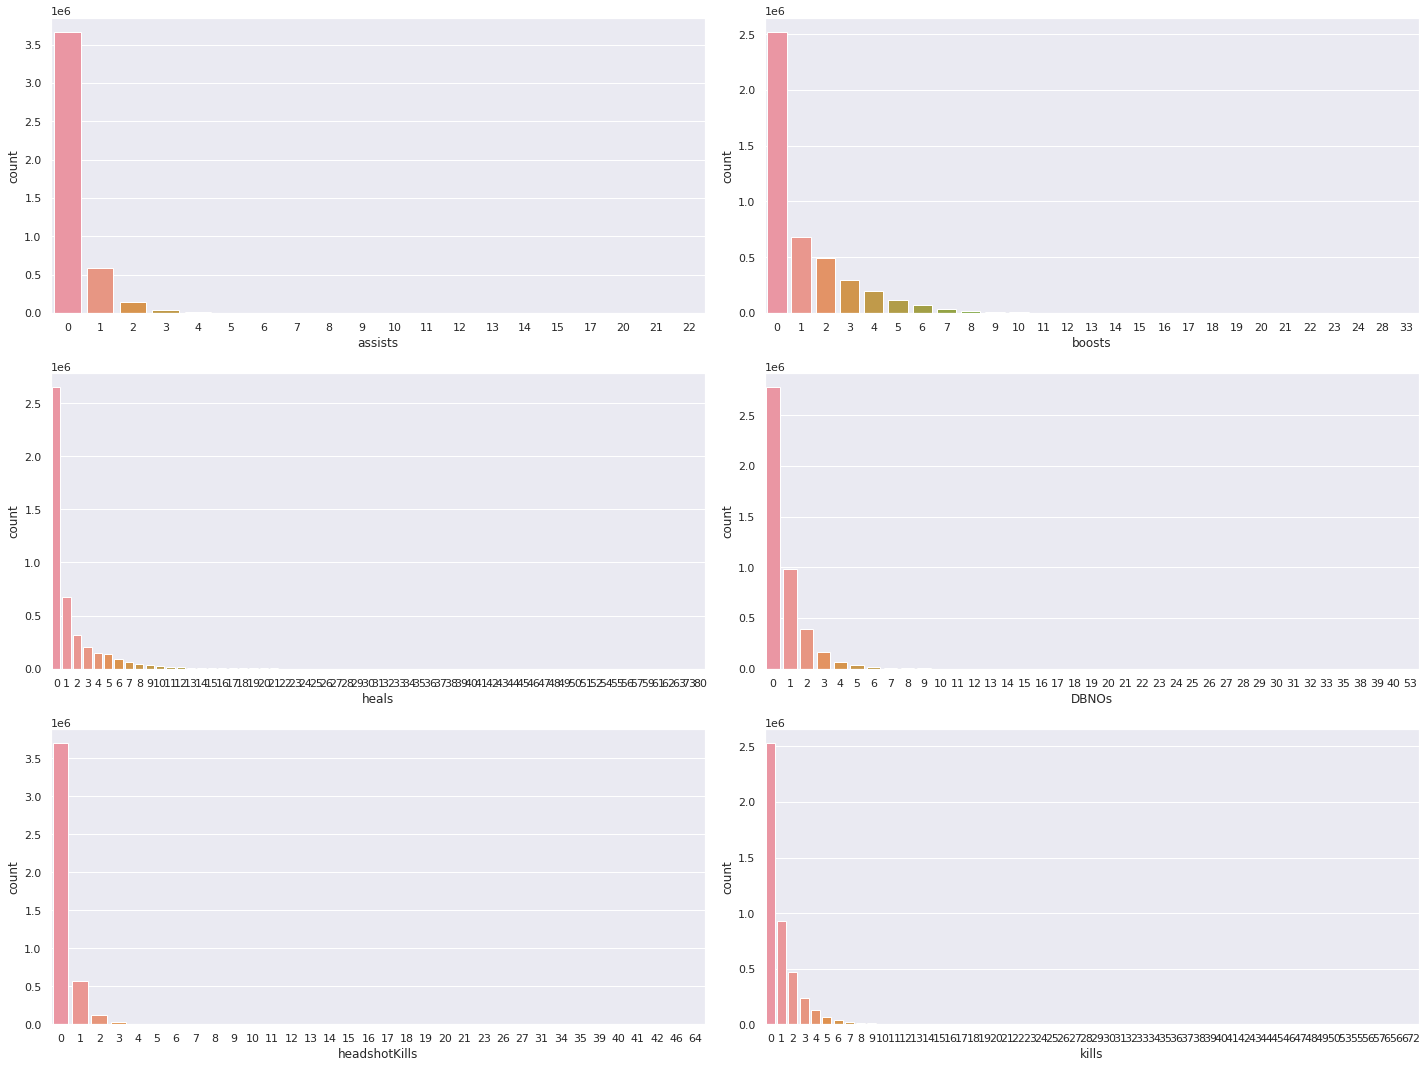

In [17]:
discreteGraph(dis_cols_1)

### Here from the graph we can see all the above feature have their most of the value lying in the zero region and their higher values graph are somewhat sparse on the basis of count.

### Player Types

In [18]:
players = train1['matchType'].value_counts()
print("Squad Players  : ",players[2])
print("Duo Players  : ",players[0])
print("Solo Players  : ",players[1])
print("Total Players : ",players[0]+players[1]+players[2])


Squad Players  :  2403625
Duo Players  :  1322628
Solo Players  :  720712
Total Players :  4446965


### So here we have the players as above distributed and the data consist of total 3112875 players

### Kills Analysis

In [19]:
print("Kills")
print("99% of the players have kills less than or equal to", train1['kills'].quantile(0.99))
print("Whereas maximum kill is ", train1['kills'].max())
print("And the minimum kill is", train1['kills'].min())

Kills
99% of the players have kills less than or equal to 7.0
Whereas maximum kill is  72
And the minimum kill is 0


### Continuous columns

In [20]:
cont_dist = ['killPoints', 'longestKill', 'maxPlace', 'rankPoints', 'rideDistance', 
             'swimDistance', 'walkDistance', 'winPoints', 'winPlacePerc']

<AxesSubplot:>

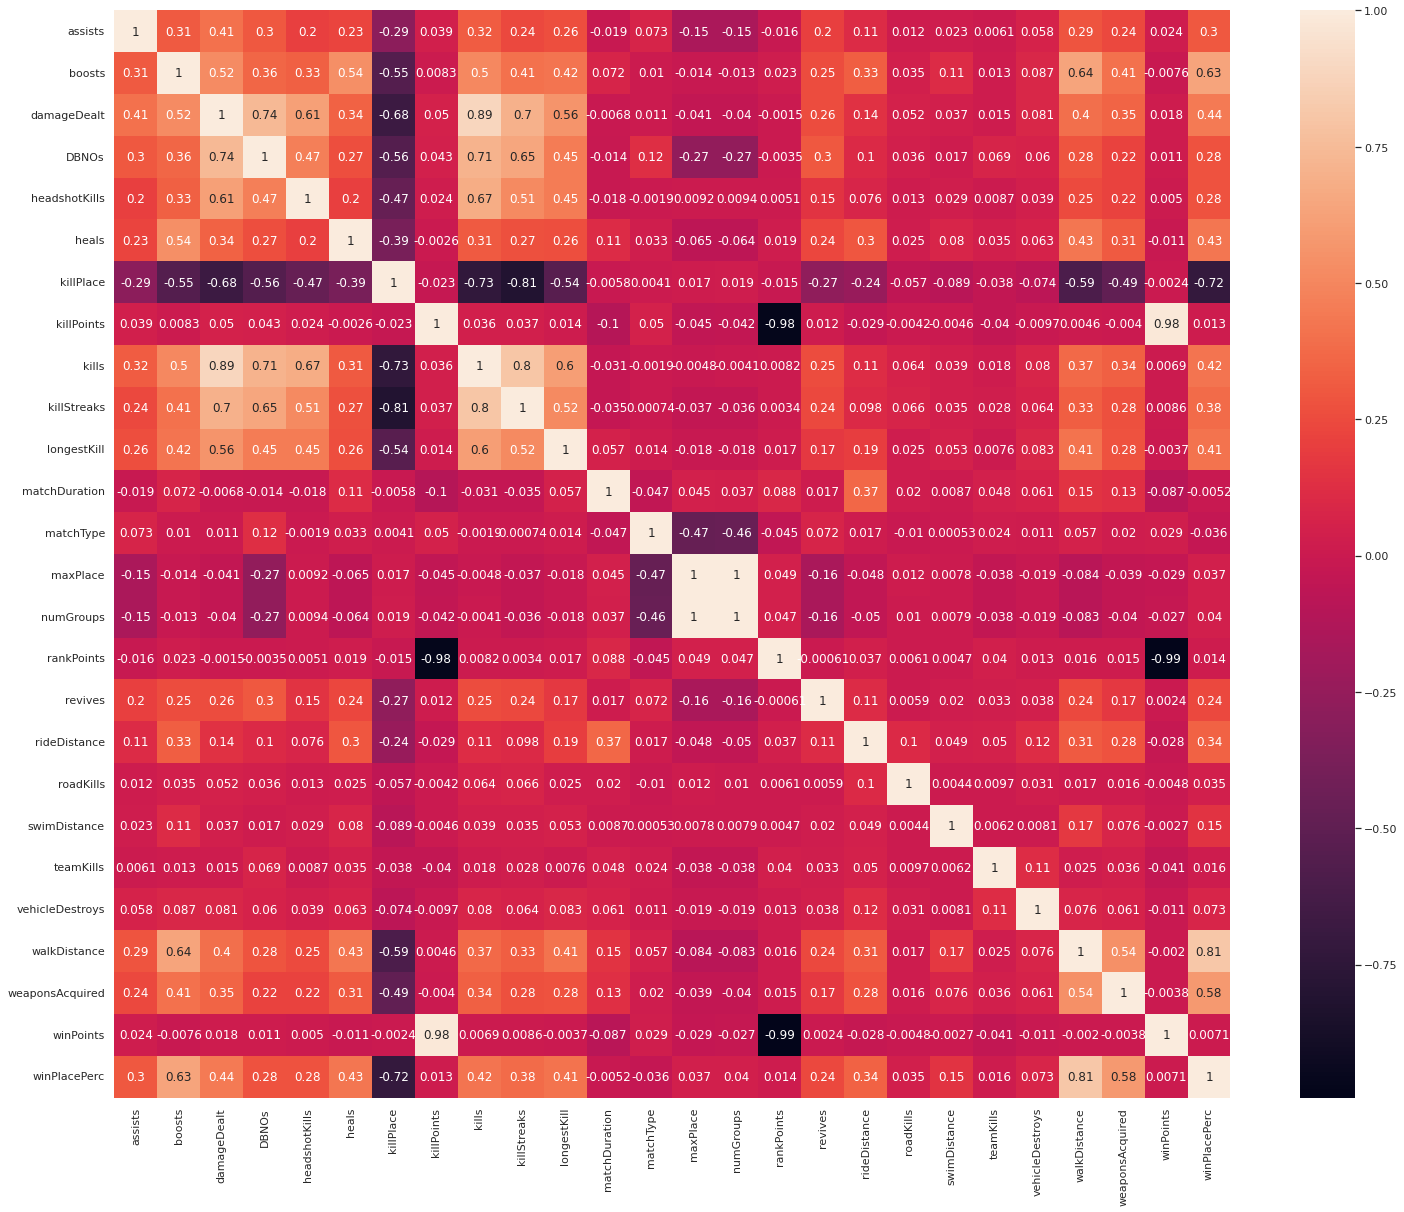

In [21]:
## Correlation matrix
plt.subplots(figsize=(25, 20))
sns.heatmap(train1.corr(), annot=True)

- We thought of reducing the dataset size by grouping the rows if they are a part of team, means a row will be a team now or an individual if its solo.
- So we have groupby the dataset by groupId and applied the aggregrate function to all the features with mean, max, min according to the feature.

- Like 
    - Kills : we have taken sum of the kills of team , walkDistance : max,
    - if the columns values are same for all the team players like
    - winPlacePerc, matchType, teamKills, etc we can take mean or max as it will be same for all the players.

    - So basically the feature which desribe any teamwork we will take sum of it ( e.g kils, assists)
    - If its a scaling feature we are taking mean of it
    - If the feature describes quality of player in a team we'll take max of it hence his/her team is affected positively

In [22]:
train2 = train.copy()
train2 = train2.groupby(by=['groupId']).agg({'matchId':'max', 'assists':'sum', 'boosts':'sum','damageDealt':'sum', 'DBNOs':'sum', 
                                            'headshotKills':'sum','heals':'sum', 'killPlace':'mean', 'killPoints':'max', 'kills':'sum',
                                            'killStreaks':'max','longestKill':'mean','matchDuration':'max', 'maxPlace':'mean','numGroups':'mean',
                                            'rankPoints' : 'max', 'matchType':'mean','revives':'sum','rideDistance':'max', 'roadKills':'sum',
                                            'swimDistance':'max','teamKills':'sum', 'vehicleDestroys':'sum', 'walkDistance':'max',
                                            'weaponsAcquired':'sum','winPoints':'max', 'winPlacePerc':'max'})



In [23]:
print("Memory Before :",(train1.memory_usage(index=True).sum()/(1024 * 1024)).round(2), " MB ")
print("Memory After : ", (train2.memory_usage(index=True).sum()/(1024 * 1024)).round(2), " MB ")

Memory Before : 339.28  MB 
Memory After :  206.82  MB 


- Here we have significantly reduced the dataset memory, but is it legit ? lets see some plots and figure out

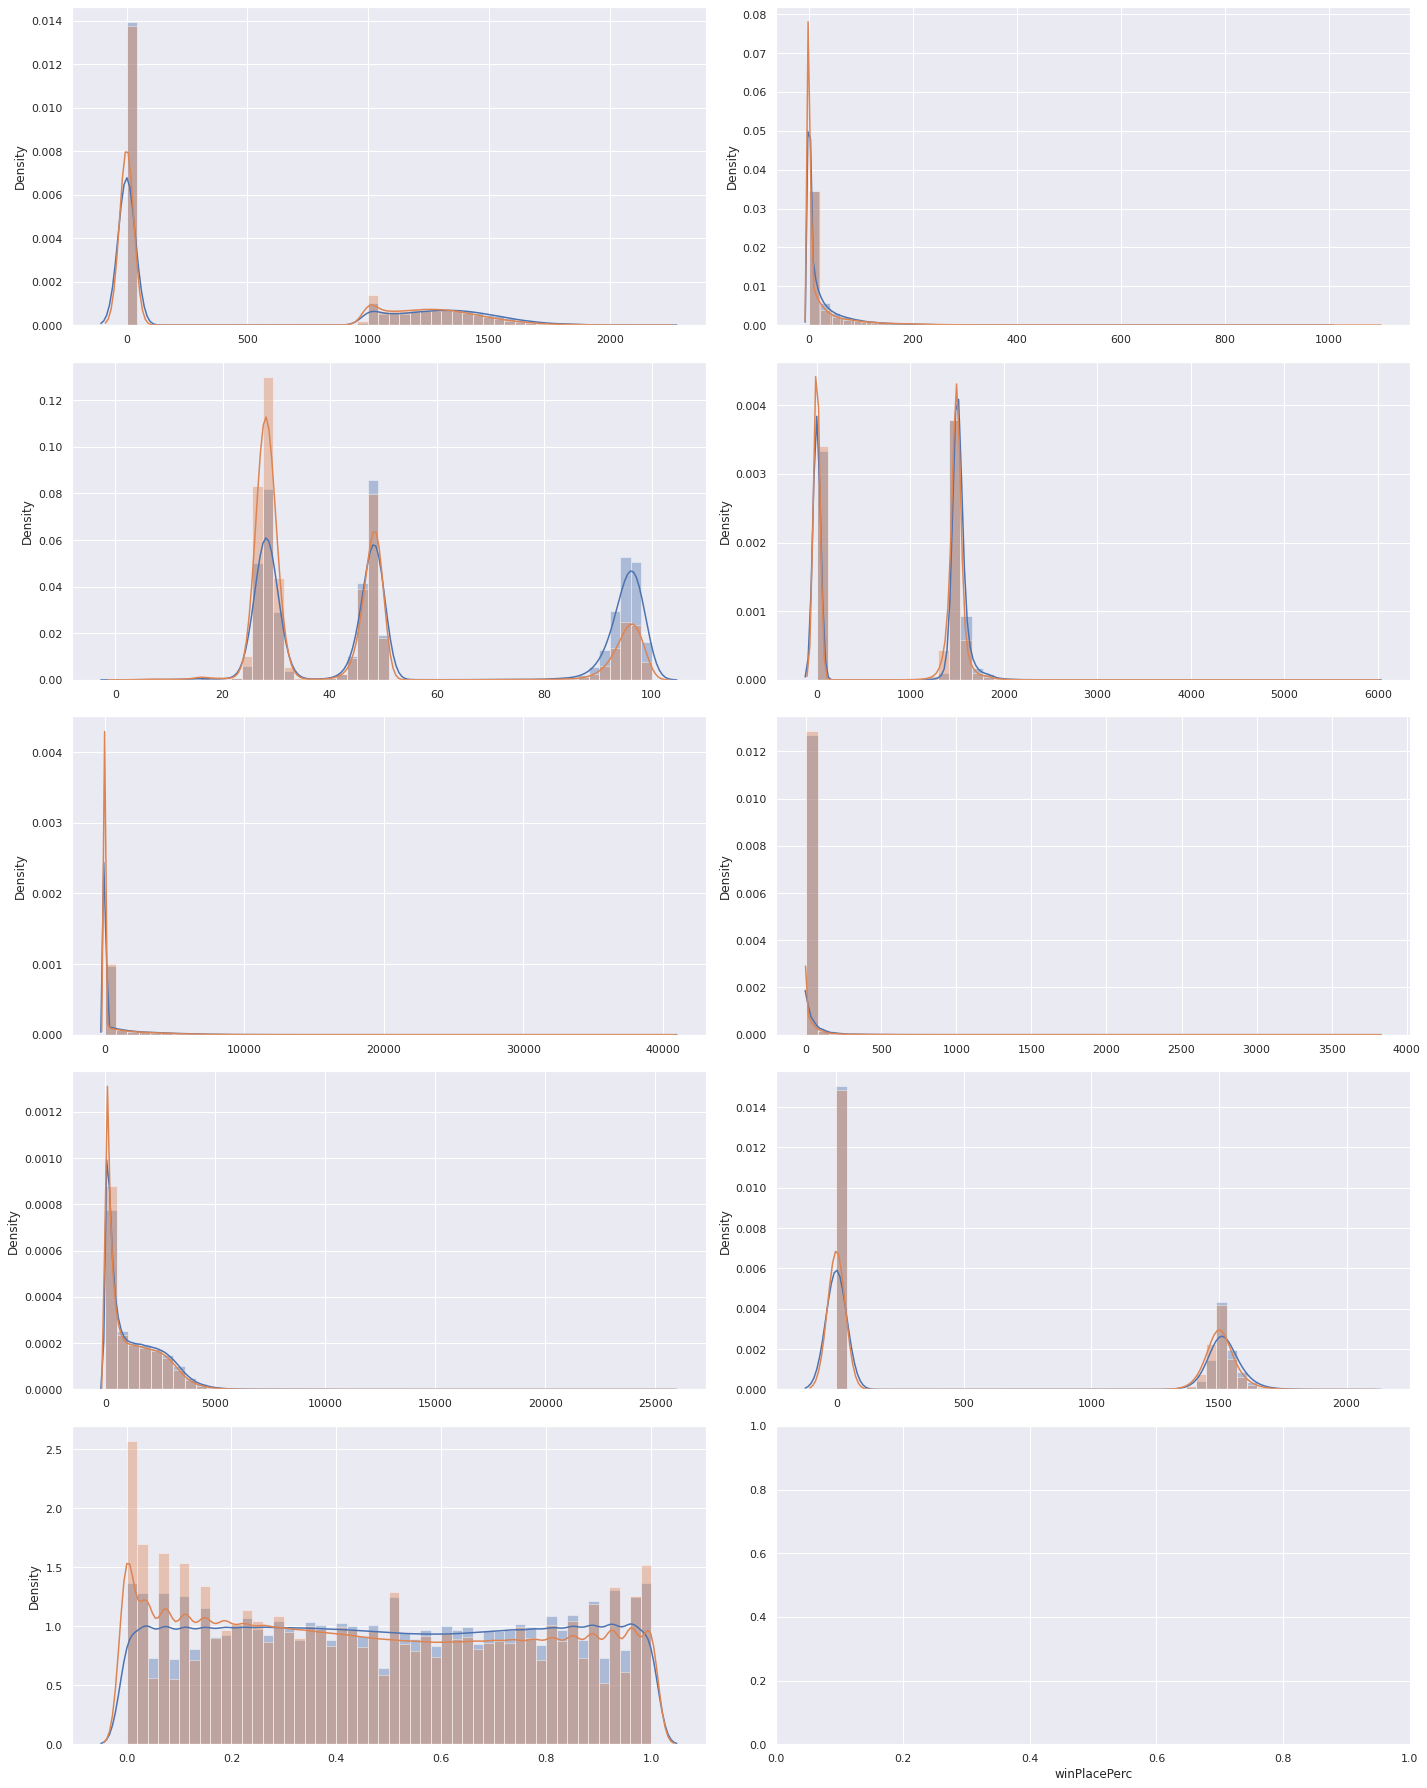

In [24]:
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
ind = 0
for i in range(5):
    for j in range(2):
        sns.distplot(train2, ax=axes[i, j], x = train2[cont_dist[ind]], kde = True)
        sns.distplot(train1, ax=axes[i, j], x = train1[cont_dist[ind]], kde = True)
        plt.xlabel(cont_dist[ind])
        ind += 1
        if(ind == len(cont_dist)):
            break
plt.tight_layout()
plt.show()

- We have plotted density graph for the original dataset and the reduced dataset looks like the both distribution looks similar.
- Also lets check the correlation of all the features with winPlacePerc before and after

### Correlation Matrix

In [25]:
cor1 = pd.DataFrame()
cor1["Original Dataset"] = train1.corr()['winPlacePerc']
cor1["Reduced Dataset"] = train2.corr()['winPlacePerc']

print(cor1)

                 Original Dataset  Reduced Dataset
assists                     0.299            0.291
boosts                      0.634            0.618
damageDealt                 0.441            0.408
DBNOs                       0.280            0.252
headshotKills               0.278            0.327
heals                       0.428            0.423
killPlace                  -0.719           -0.797
killPoints                  0.013            0.007
kills                       0.420            0.427
killStreaks                 0.378            0.376
longestKill                 0.410            0.482
matchDuration              -0.005            0.003
matchType                  -0.036            0.002
maxPlace                    0.037           -0.003
numGroups                   0.040           -0.003
rankPoints                  0.014            0.010
revives                     0.241            0.265
rideDistance                0.343            0.338
roadKills                   0.0

- Hence from the above result there is not much of difference of correlation of feature wih winPlacePerc too
- So going forward the reduced dataset can be a candidate for the training purpose

Text(0, 0.5, 'Boosts')

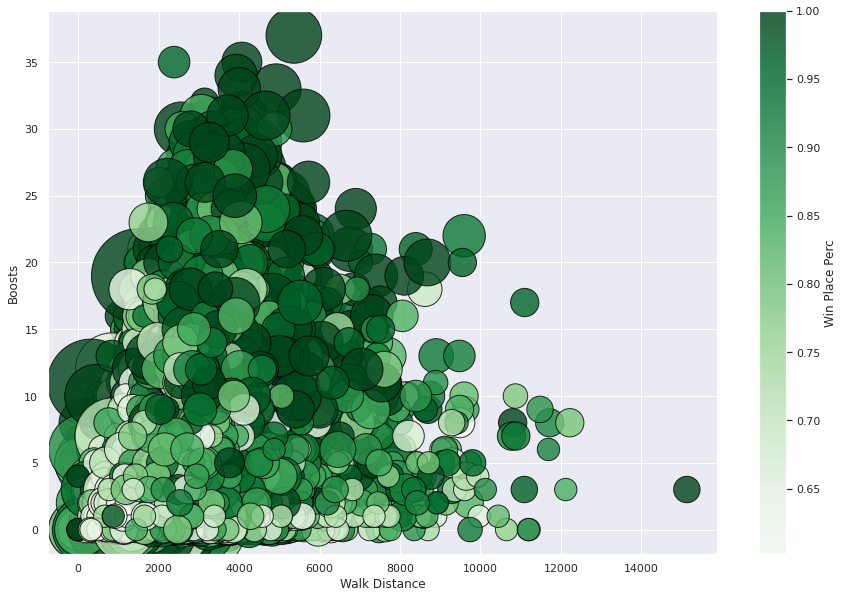

In [26]:
temp1 = train2[train2['winPlacePerc']>0.6].sample(100000)
plt.figure(figsize=(15, 10))
plt.scatter(temp1['walkDistance'], temp1['boosts'], s=(temp1['kills']+5)*100, c=temp1['winPlacePerc'], cmap='Greens', edgecolor='black', linewidth=1, alpha=0.8)
cbar = plt.colorbar()
cbar.set_label("Win Place Perc")
plt.xlabel("Walk Distance")
plt.ylabel("Boosts")

### From the above graph we can observe that as boosts consumption increases players chance to win the match increases, also logically a player which has high chance of winning tends to be in fight and needs boost also we can see walkDistance also matters in winnning as it will be high for the player/team who has high chances of winning, because to be in the game players have to be in safe zone for that they need to travel.

Text(0, 0.5, 'Boosts')

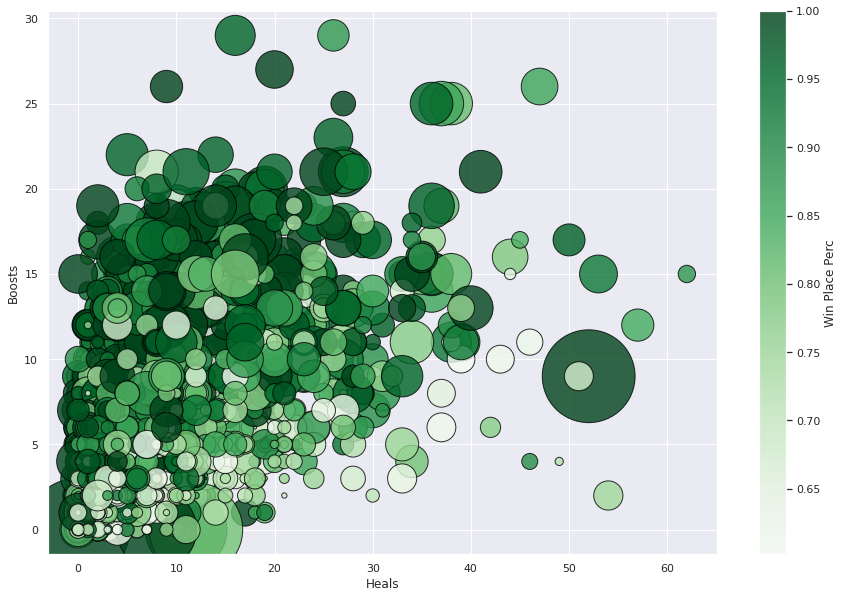

In [27]:
temp1 = train2[train2['winPlacePerc']>0.6].sample(5000)
plt.figure(figsize=(15, 10))
plt.scatter(temp1['heals'], temp1['boosts'], s=temp1['damageDealt'], c=temp1['winPlacePerc'], cmap='Greens', edgecolor='black', linewidth=1, alpha=0.8)
cbar = plt.colorbar()
cbar.set_label("Win Place Perc")
plt.xlabel("Heals")
plt.ylabel("Boosts")

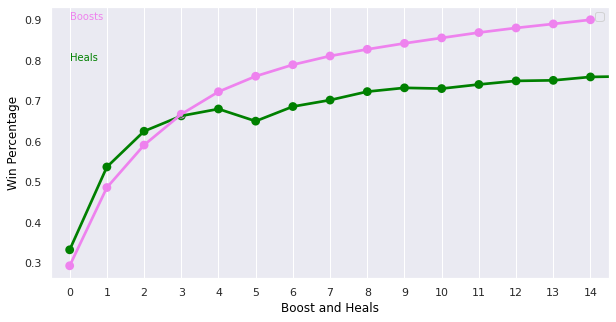

In [28]:
temp2 = train2[train2['heals'] < train2['heals'].quantile(0.99)]
temp2 = temp2[temp2['boosts'] < temp2['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(10,5))
sns.pointplot(x='heals',y='winPlacePerc',data=temp2,color='green')
sns.pointplot(x='boosts',y='winPlacePerc',data=temp2,color='violet')
plt.text(0,0.8,'Heals',color='green',fontsize = 10)
plt.text(0,0.9,'Boosts',color='violet',fontsize = 10)
plt.ylabel('Win Percentage', color='black')
plt.xlabel('Boost and Heals', color='black')
plt.grid()
plt.legend()

### From the above graph we can see Boosts and Heals shows positive relation with winPlacePerc, Boosts shows more than Heal. Maybe we can do some stuff with both of these feature later

<AxesSubplot:xlabel='kills', ylabel='winPlacePerc'>

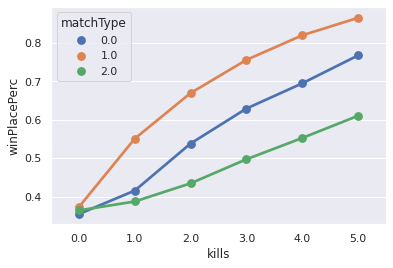

In [29]:
temp = train2[train2['kills'] <= train2['kills'].quantile(.9)]
sns.pointplot(x='kills',y='winPlacePerc',data=temp, hue='matchType')

# duo   - 0
# solo  - 1
# squad - 2

### From the above graph we can say that as the number of kills increases chances of winning increases but it does not matter much as we go from match type from solo to squad, because in squad we have to play more strategically and focus is not much on kills in squad

### While Analyzing the dataset we found some irregularities in the data, so handling those anomalies now

In [30]:
train4 = train2.copy()

### 1) Have done kills but have not travel any distance

<AxesSubplot:xlabel='kills', ylabel='count'>

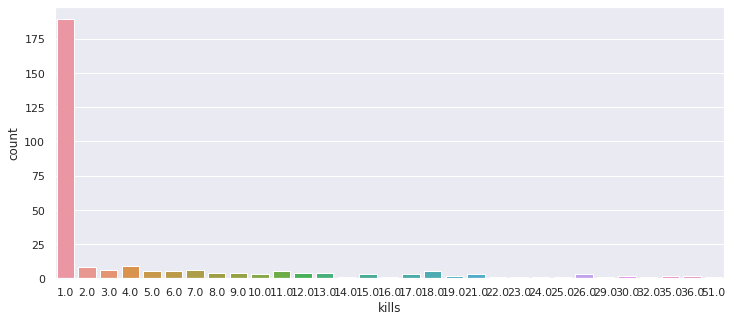

In [31]:
plt.figure(figsize=(12, 5))
sns.countplot(x='kills', data=train4[(train4['walkDistance'] + train4['rideDistance'] + train4['swimDistance']==0) & (train4['kills'] > 0)])

### So the above graph is of the players who travel zero distance yet they have killed enemies seems suspicious, hence removing those rows!!

In [32]:
train4.drop(train4[(train4['walkDistance'] + train4['rideDistance'] + train4['swimDistance']==0) & (train4['kills'] > 0)].index, axis=0, inplace = True)

### 2)

<AxesSubplot:xlabel='kills', ylabel='count'>

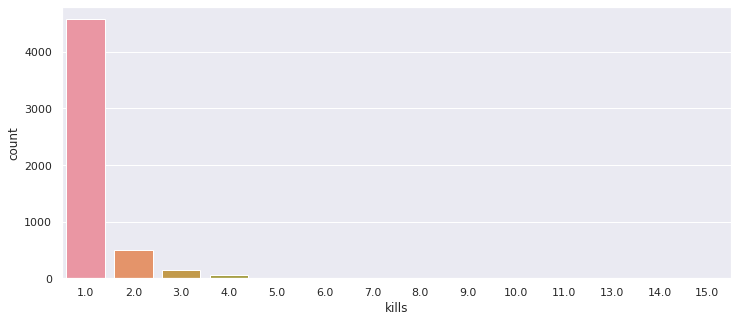

In [33]:
plt.figure(figsize=(12, 5))
sns.countplot(x='kills', data=train4[(train4['longestKill']==0) & (train4['kills'] > 0)])

### So here we can see the longest kill is zero yet there are some non-zero kills, hence dropping those rows too!

In [34]:
index_drop = train4[(train4['longestKill']==0) & (train4['kills'] > 0)].index
train4.drop(index_drop,axis= 0,inplace= True)

### 3)

<AxesSubplot:xlabel='teamKills', ylabel='count'>

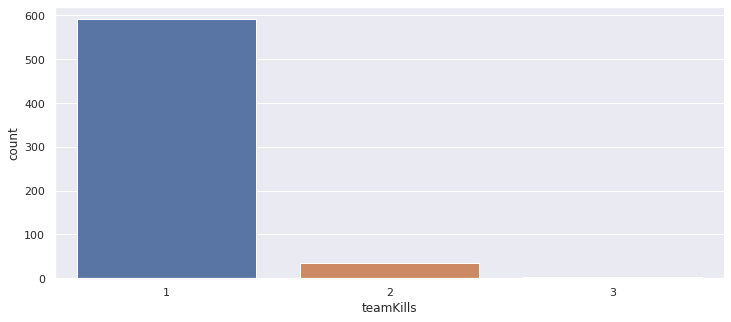

In [35]:
plt.figure(figsize=(12, 5))
sns.countplot(x='teamKills', data=train4[(train4['weaponsAcquired']==0) & (train4['teamKills']>0) & (train4['rideDistance']==0)])

### In pubg, a player can kill his/her team-mate only if he has grenade(weapon) or he/she has drove a vehicle over his/her team-mate. But from the above condition graph there are some players who have killed teamplayer yet they have not acquire any weapon or drove a car/vehicle!!

In [36]:
index_drop = train4[(train4['weaponsAcquired']==0) & (train4['teamKills']>0) & (train4['rideDistance']==0)].index
train4.drop(index_drop, axis=0, inplace = True)
print(len(index_drop), " rows dropped!!")

628  rows dropped!!


### 4)

<AxesSubplot:xlabel='roadKills', ylabel='count'>

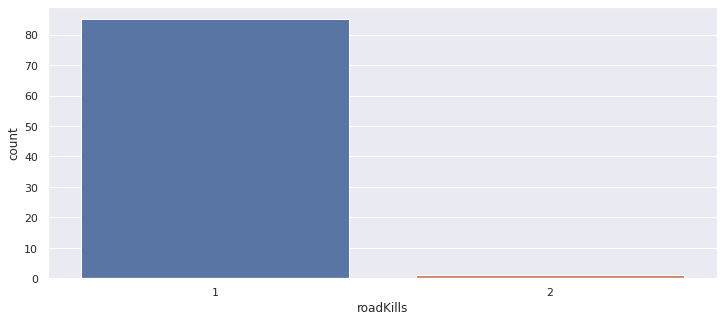

In [37]:
plt.figure(figsize=(12, 5))
sns.countplot(x='roadKills', data=train4[(train4['roadKills']>0) & (train4['rideDistance']==0)])

### Killing players  from the car but have not ride the car=> illegal data

In [ ]:
index_drop = train4[(train4['roadKills']>0) & (train4['rideDistance']==0)].index
print(index_drop.shape)
train4.drop(index_drop, axis=0, inplace = True)

### 5) Have not walked but have consumed heals and boost, its not possible

In [39]:
index_drop = train4[((train4['heals']>0) | (train4['boosts']>0)) & (train4['walkDistance']==0)].index
print(index_drop.shape)
train4.drop(index_drop, axis=0, inplace = True)

(166,)


### Similarly we have observed some more anamolies like as below:

### 6) Its not possible to acquire weapon if a player has not walked a distamce

In [40]:
index_drop = train4[(train4['weaponsAcquired']>0) & (train4['walkDistance']==0)].index
print(index_drop.shape)
train4.drop(index_drop, axis=0, inplace = True) 

(6475,)


### 7) If matchType is solo then there cannot be any assists value, because to assist we need teammate which we don't have, here as the number are somewhat high, so instead of dropping the rows, we imputed that feature with 0.

In [41]:
index_replace = train4[(train4['matchType']==1) & (train4['assists']>0)].index
print(index_replace.shape)
train4.loc[index_replace,'assists'] = 0

(39422,)


### 8) A player cannot assist a teammate if the walkDistance is 0

In [42]:
index_drop = train4[(train4['assists']>0) & (train4['walkDistance']==0)].index
print(index_drop.shape)
train4.drop(index_drop, axis=0, inplace = True)

(6,)


### 9) A player cannot dealt damage if he has not walked a single meter

In [43]:
index_drop = train4[(train4['damageDealt']>0) & (train4['walkDistance']==0)].index
print(index_drop.shape)
train4.drop(index_drop, axis=0, inplace = True)

(857,)


### Correlation Matrix

<AxesSubplot:>

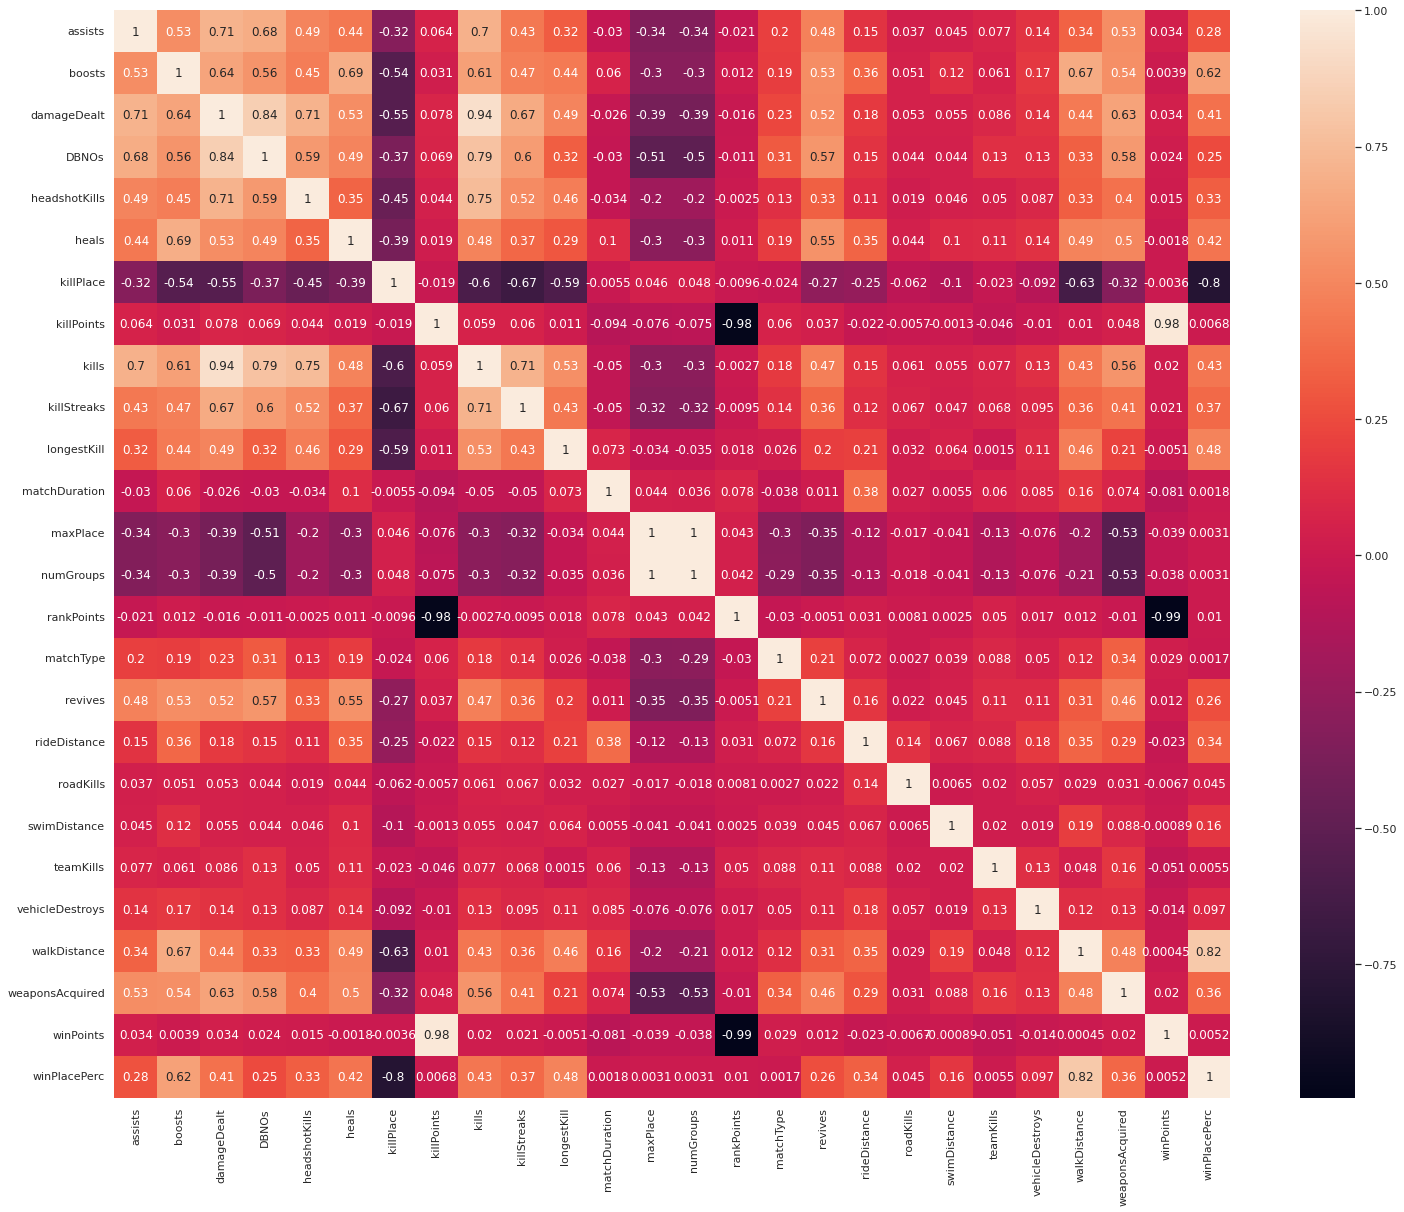

In [44]:
plt.subplots(figsize=(25, 20))
sns.heatmap(train4.corr(), annot=True)

In [45]:
def getCorrelatedFeatures(corrdata, threshold):
    train_features = []
    train_value = []
    for i,index in enumerate(corrdata.index):
        if abs(corrdata[index])>threshold:
            train_features.append(index)
            train_value.append(corrdata[index])
            
    df = pd.DataFrame(data = train_value, index = train_features,columns = ['CorrValue'] )
    return df,train_features

In [46]:
threshold = 0.4
corr_value,train_features = getCorrelatedFeatures(train4.corr()['winPlacePerc'],threshold)
print(corr_value)

              CorrValue
boosts            0.618
damageDealt       0.408
heals             0.422
killPlace        -0.796
kills             0.427
longestKill       0.482
walkDistance      0.815
winPlacePerc      1.000


In [47]:
train4 = train4.reset_index()

In [48]:
# train4.to_csv("Train-GroupByGroupId-RemovedRows.csv", index=False)

In [49]:
for column_name in train4:
    if train4[column_name].dtype=='float64':
        train4[column_name] = pd.to_numeric(train4[column_name], downcast= 'float')
    if train4[column_name].dtype=='int64':
        train4[column_name] = pd.to_numeric(train4[column_name],downcast='integer')

### Feature Engineering

In [50]:
train5 = train4.copy()

In [51]:
def feature_engineering(train5):
    train5.insert(train5.shape[1]-1, 'killsPerMeter', train5['kills']/train5['walkDistance'])
    train5['killsPerMeter'].fillna(0, inplace=True)
    train5['killsPerMeter'].replace(np.inf, 0, inplace=True)

    train5.insert(train5.shape[1]-1, 'healsPerMeter', train5['heals']/train5['walkDistance'])
    train5['healsPerMeter'].fillna(0, inplace=True)
    train5['healsPerMeter'].replace(np.inf, 0, inplace=True)

    train5.insert(train5.shape[1]-1, 'totalHeals', train5['heals']+train5['boosts'])

    train5.insert(train5.shape[1]-1, 'totalHealsPerMeter', train5['totalHeals']/train5['walkDistance'])
    train5['totalHealsPerMeter'].fillna(0, inplace=True)
    train5['totalHealsPerMeter'].replace(np.inf, 0, inplace=True)

    train5.insert(train5.shape[1]-1, 'totalDistance', train5['walkDistance']+train5['rideDistance']+train5['swimDistance'])
    train5['totalDistance'].fillna(0, inplace=True)
    train5['totalDistance'].replace(np.inf, 0, inplace=True)

    train5.insert(train5.shape[1]-1, 'headshotRate', train5['headshotKills']/train5['kills'])
    train5['headshotRate'].fillna(0, inplace=True)
    train5['headshotRate'].replace(np.inf, 0, inplace=True)

    train5.insert(train5.shape[1]-1, 'assistsAndRevives', train5['assists']+train5['revives'])

    train5.insert(train5.shape[1]-1, 'itemsAcquired', train5['heals']+train5['boosts']+train5['weaponsAcquired'])
    
    return train5

In [52]:
train5 = feature_engineering(train5)

In [53]:
train5.corr()['winPlacePerc']

assists               0.283
boosts                0.618
damageDealt           0.408
DBNOs                 0.250
headshotKills         0.326
heals                 0.422
killPlace            -0.796
killPoints            0.007
kills                 0.427
killStreaks           0.374
longestKill           0.482
matchDuration         0.002
maxPlace              0.003
numGroups             0.003
rankPoints            0.010
matchType             0.002
revives               0.264
rideDistance          0.337
roadKills             0.045
swimDistance          0.165
teamKills             0.005
vehicleDestroys       0.097
walkDistance          0.815
weaponsAcquired       0.361
winPoints             0.005
killsPerMeter        -0.110
healsPerMeter         0.054
totalHeals            0.543
totalHealsPerMeter    0.053
totalDistance         0.657
headshotRate          0.170
assistsAndRevives     0.319
itemsAcquired         0.522
winPlacePerc          1.000
Name: winPlacePerc, dtype: float64

In [54]:
# train5.to_csv("Train-GroupByGroupId-RemovedRows-FeatureEng.csv", index=False)


In [55]:
# train5 = pd.read_csv("../input/Train-GroupByGroupId-RemovedRows-FeatureEng/Train-GroupByGroupId-RemovedRows-FeatureEng.csv")

<h1> <b>Reformatting test data  </b></h1>

In [56]:
test = pd.read_csv("/kaggle/input/pubg-finish-placement-prediction/test_V2.csv")
for column_name in test:
    if test[column_name].dtype=='float64':
        test[column_name] = pd.to_numeric(test[column_name], downcast= 'float')
    if test[column_name].dtype=='int64':
        test[column_name] = pd.to_numeric(test[column_name],downcast='integer')

In [57]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
test['matchType'] = test['matchType'].apply(lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad')
test['matchType'] = labelencoder.fit_transform(test['matchType'])
test['matchType'].value_counts()

2    1033085
0     587165
1     313924
Name: matchType, dtype: int64

In [58]:
mapping = dict(zip(labelencoder.classes_, range(len(labelencoder.classes_))))
mapping

{'duo': 0, 'solo': 1, 'squad': 2}

In [59]:
test1 = test.groupby(by=['groupId']).agg({'matchId':'max', 'assists':'sum', 'boosts':'sum','damageDealt':'sum', 'DBNOs':'sum', 
                                            'headshotKills':'sum','heals':'sum', 'killPlace':'mean', 'killPoints':'max', 'kills':'sum',
                                            'killStreaks':'max','longestKill':'mean','matchDuration':'max', 'maxPlace':'mean','numGroups':'mean',
                                            'rankPoints' : 'max', 'matchType':'mean','revives':'sum','rideDistance':'max', 'roadKills':'sum',
                                            'swimDistance':'max','teamKills':'sum', 'vehicleDestroys':'sum', 'walkDistance':'max',
                                            'weaponsAcquired':'sum','winPoints':'max'})


In [60]:
test1 = test1.reset_index()

In [61]:
# test1.to_csv("Test-GroupByGroupId.csv", index=False)
# test1 = pd.read_csv("../input/Test-GroupByGroupId/Test-GroupByGroupId.csv")

In [62]:
test2 = test1.copy()

def fea_eng_test(test2):
    test2.insert(test2.shape[1], 'killsPerMeter', test2['kills']/test2['walkDistance'])
    test2['killsPerMeter'].fillna(0, inplace=True)
    test2['killsPerMeter'].replace(np.inf, 0, inplace=True)

    test2.insert(test2.shape[1], 'healsPerMeter', test2['heals']/test2['walkDistance'])
    test2['healsPerMeter'].fillna(0, inplace=True)
    test2['healsPerMeter'].replace(np.inf, 0, inplace=True)

    test2.insert(test2.shape[1], 'totalHeals', test2['heals']+test2['boosts'])

    test2.insert(test2.shape[1], 'totalHealsPerMeter', test2['totalHeals']/test2['walkDistance'])
    test2['totalHealsPerMeter'].fillna(0, inplace=True)
    test2['totalHealsPerMeter'].replace(np.inf, 0, inplace=True)

    test2.insert(test2.shape[1], 'totalDistance', test2['walkDistance']+test2['rideDistance']+test2['swimDistance'])
    test2['totalDistance'].fillna(0, inplace=True)
    test2['totalDistance'].replace(np.inf, 0, inplace=True)

    test2.insert(test2.shape[1], 'headshotRate', test2['headshotKills']/test2['kills'])
    test2['headshotRate'].fillna(0, inplace=True)
    test2['headshotRate'].replace(np.inf, 0, inplace=True)

    test2.insert(test2.shape[1], 'assistsAndRevives', test2['assists']+test2['revives'])

    test2.insert(test2.shape[1], 'itemsAcquired', test2['heals']+test2['boosts']+test2['weaponsAcquired'])
    
    return test2

In [63]:
test2 = fea_eng_test(test2)

In [64]:
# test2.to_csv("Test-GroupByGroupId-FeatureEng.csv", index=False)

# test2  = pd.read_csv("../input/Test-GroupByGroupId-FeatureEng/Test-GroupByGroupId-FeatureEng.csv")

# LightGBM Model

In [65]:
X = train5.drop(['groupId', 'matchId', 'winPlacePerc'], axis=1)
y = train5['winPlacePerc']

In [66]:
def model_train(model,Xt_train,Xt_test,yt_train, yt_test):
    model.fit(Xt_train,yt_train)
    score= model.score(Xt_train,yt_train)
    y_pred = model.predict(Xt_test)
    mse = mean_squared_error(yt_test, y_pred)
    print("MSE: {0:.6f}".format(mse))
    print("Training Score:{0:.6f}".format(score)) 

In [67]:
lgbm_for_reg= LGBMRegressor(colsample_bytree=0.8, learning_rate=0.03, max_depth=30,
              min_split_gain=0.00015, n_estimators=250, num_leaves=2200,reg_alpha=0.1, reg_lambda=0.001, subsample=0.8,
              subsample_for_bin=45000, n_jobs =-1, max_bin =700, num_iterations=5100, min_data_in_bin = 12)

## LightGBM Train Model

In [68]:
lgbm_for_reg.fit(X,y,verbose=1700, eval_set=[(X, y)],early_stopping_rounds=10)

[1700]	training's l2: 0.00176304
[3400]	training's l2: 0.00101728
[5100]	training's l2: 0.000821426


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.03, max_bin=700,
              max_depth=30, min_data_in_bin=12, min_split_gain=0.00015,
              n_estimators=250, num_iterations=5100, num_leaves=2200,
              reg_alpha=0.1, reg_lambda=0.001, subsample=0.8,
              subsample_for_bin=45000)

## Importanat Parameter

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

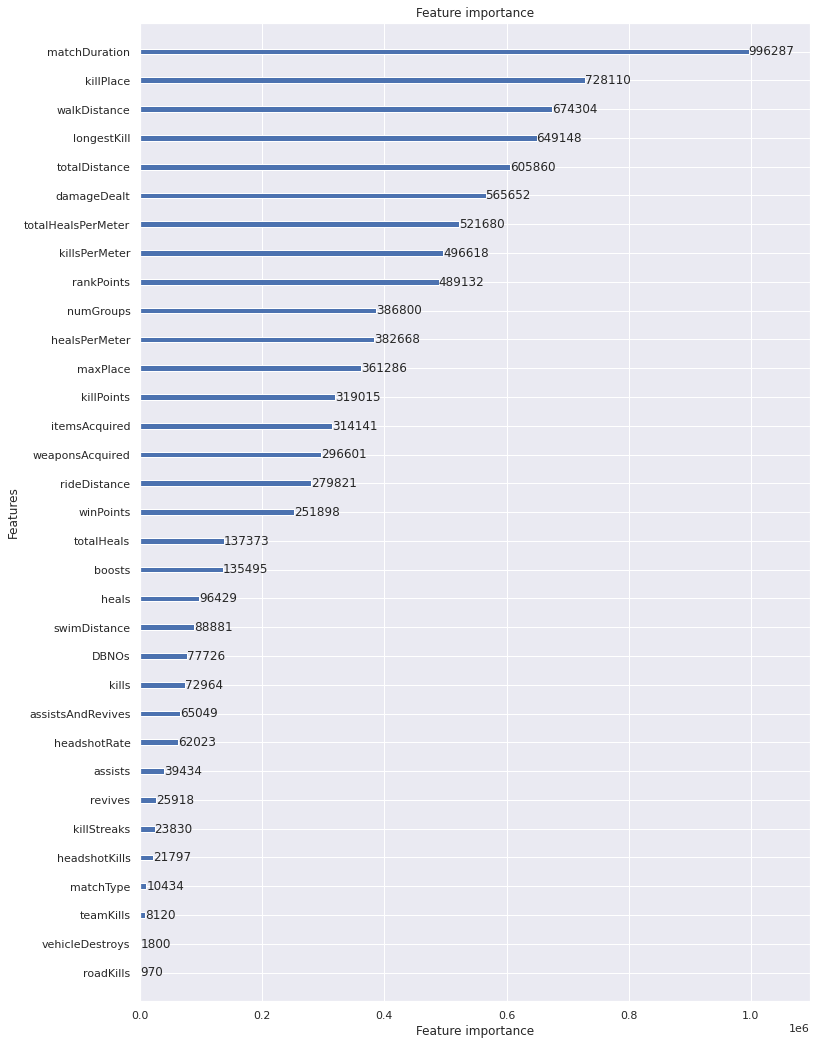

In [69]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(lgbm_for_reg, max_num_features=50,ax=ax)

## Pridiction of Test dataset

In [70]:
test2 = test2.drop(['groupId', 'matchId'], axis=1)

In [ ]:
ypred = lgbm_for_reg.predict(test2)

## Reformatting of test data

In [ ]:
def submitFormat(test, ypred):
    res = test[['Id', 'groupId']]
    res = res.groupby(by=['groupId']).agg(list)
    res['winPlacePerc'] = ypred.tolist()
    res = res.explode('Id')
    res.reset_index(inplace = True)
    res = res[['Id','winPlacePerc']]
    res['winPlacePerc'].round(decimals = 3)
    return res

In [ ]:
res = submitFormat(test, ypred)

In [ ]:
res["winPlacePerc"] = np.where(res["winPlacePerc"] <0, 0, res["winPlacePerc"])
res["winPlacePerc"] = np.where(res["winPlacePerc"] >1, 1, res["winPlacePerc"])

In [77]:
res

,Id,winPlacePerc
0,91fce235ef7633,0.660
1,34a29404226c8c,0.660
2,b42438a58754e1,0.660
3,b3c0c8dca728eb,0.292
4,2d129525967d5f,0.292
...,...,...
1934169,9fa2af7716dba8,0.267
1934170,be817d15887a5b,0.054
1934171,b53b513530c3dd,0.054
1934172,d06903e040d9bb,0.054


## Generate submission File

In [ ]:
res.to_csv("submission.csv", index=False)